In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pickle
import pyproj

from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

from preprocessing.encoding_pipeline import processing_pipe

# Importing and preprocessing clean data

In [3]:
clean_data = gpd.read_file("../raw_data/project_data_clean.shp")

In [4]:
X_clean = clean_data.drop(columns=['green_roof', 'geometry'])
y = clean_data['green_roof']

In [5]:
X = processing_pipe(X_clean)

In [6]:
X.shape

(18015, 74)

# Model training, evaluation and export

In [7]:
model_params = {'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'init': None,
 'learning_rate': 0.09,
 'loss': 'exponential',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 6,
 'min_samples_split': 100,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [8]:
model = GradientBoostingClassifier(**model_params).fit(X, y)

In [9]:
y_pred_proba = model.predict_proba(X)[:,1]

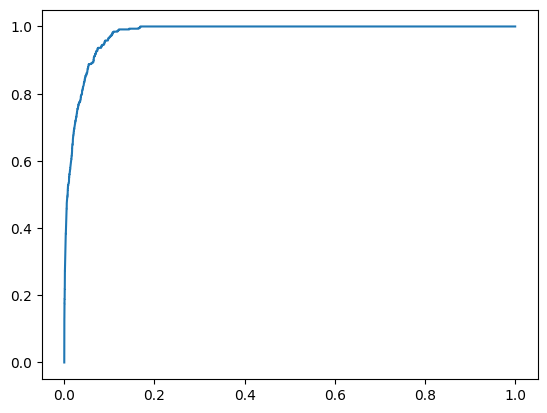

In [10]:
fpr, tpr, thresholds = metrics.roc_curve(y, y_pred_proba)
auc = metrics.roc_auc_score(y, y_pred_proba)

plt.plot(fpr,tpr,label= str(auc));

In [11]:
# Choosing classification threshold to compensate for unbalanced data
metrics_data = pd.DataFrame({'tpr':tpr, 'fpr':fpr, 'thresholds':thresholds})

threshold = 0.024697

In [12]:
def custom_predict_proba(y_pred, threshold):
    """Function applies different threshold for final classification.
    For scores above the threshold classifiers returns 1.
    For scores under the threshold classifiers returns relative score w.r.t threshold.
    """
    predictions = []
    if y_pred.ndim == 1:
        for pred in y_pred:
            if pred >= threshold:
                predictions.append(1)
            else:
                predictions.append(round(pred/threshold,3))
    else:
        for pred in y_pred[:,1]:
            if pred >= threshold:
                predictions.append(1)
            else:
                predictions.append(round(pred/threshold,3))
    return predictions

In [13]:
# Computes scores w.r.t to threshold
y_pred_threshold =  custom_predict_proba(y_pred_proba, threshold)
y_pred = y_pred_proba>threshold

In [14]:
cm = metrics.confusion_matrix(y, y_pred_proba>threshold)
tpr = cm[1][1]/(cm[1][1]+cm[1][0])
fpr = cm[0][1]/(cm[0][0]+cm[0][1])

print(cm)

print('tpr is:',tpr)
print('fpr is:',fpr)

tt = f"""This means that the model is capable of predicting {100 * tpr}% of the of the green roofs 
and { 100 * (1 - fpr)}% of the non-green roofs correctly.
"""
print(tt)

[[16179  1380]
 [   29   427]]
tpr is: 0.9364035087719298
fpr is: 0.07859217495301554
This means that the model is capable of predicting 93.64035087719299% of the of the green roofs 
and 92.14078250469845% of the non-green roofs correctly.



In [15]:
# Create model pickle file
# model_file = "../pickle/model.pkl"
# pickle.dump(model, open(model_file, 'wb'))

# Visualization

In [16]:
# selecting the geometry column and converting the reference system
geometry = clean_data['geometry'].to_crs(pyproj.CRS.from_epsg(4326))

In [17]:
# organizing the dataframe for visualization
df_vis = clean_data.copy()
df_vis['geometry'] = geometry
df_vis['green_roof_pred'] = y_pred
df_vis['green_roof_pred_thresh'] = y_pred_threshold

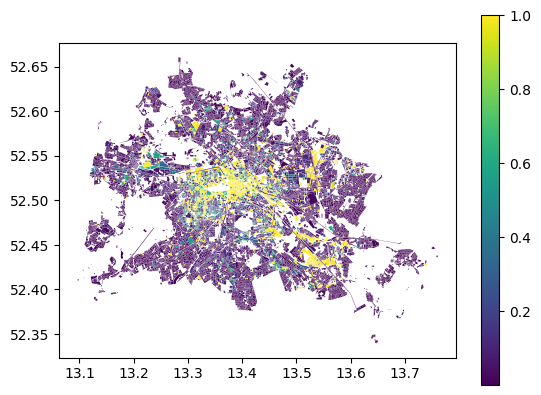

In [18]:
# plotting predicted probabilities
df_vis.plot(column = 'green_roof_pred_thresh', cmap = 'viridis', legend = True);

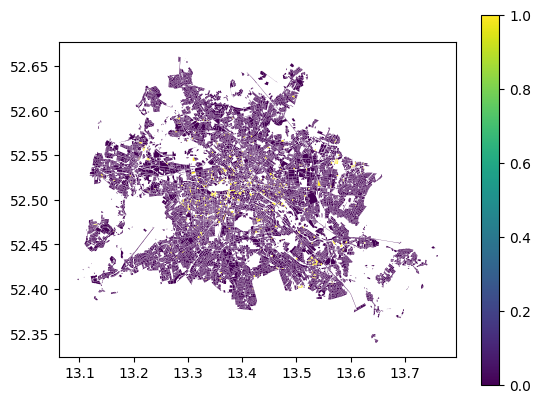

In [19]:
# plotting real green roofs situation
df_vis.plot(column = 'green_roof', cmap = 'viridis', legend = True);

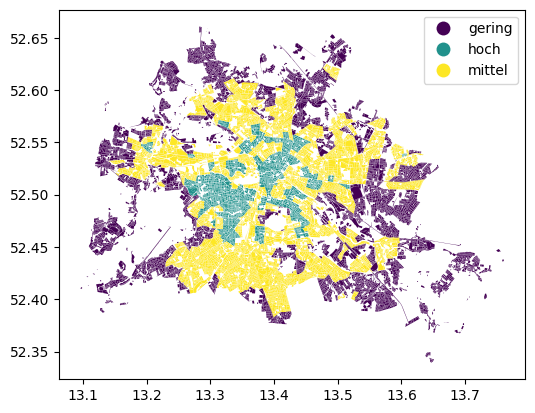

In [20]:
# plotting air pollution
df_vis.plot(column = 'air_pollut', cmap = 'viridis', legend = True);

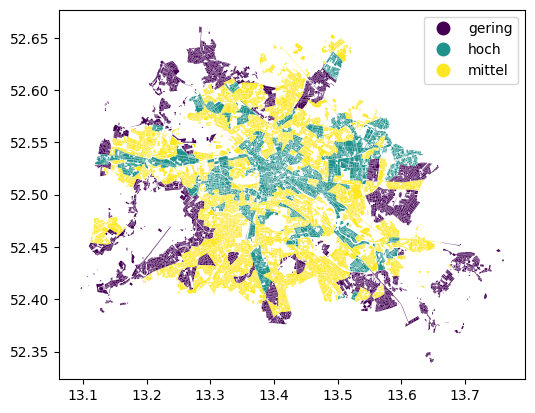

In [21]:
# plotting thremal stress
df_vis.plot(column = 'thermal_st', cmap = 'viridis', legend = True);